# Simple Moving Average Crossover Backtest Demo

This notebook demonstrates a full backtesting pipeline using the modular framework:
0. Install Dependencies (if needed)
1. Setup Environment
2. Import modules
3. Load price and risk-free rate data
4. Generate trading signals (SMA Crossover for SPY)
   - Includes detailed inspection of signals and SMAs
5. Run the backtest simulation
6. Display performance metrics
7. Plot equity curve and drawdown periods

### 0. Install Dependencies

This cell installs the `yfinance` library if it's not already present. After running this for the first time (if it installs anything), you might need to **restart the kernel**.

In [1]:
!pip install yfinance pandas matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


### 1. Setup Environment

Add the project's root directory to the Python path to allow importing the `src` package.

In [2]:
import sys
import pathlib

project_root = pathlib.Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Added project root {project_root} to sys.path")
else:
    print(f"Project root {project_root} already in sys.path")

Added project root /workspaces/Backtest-Simple to sys.path


### 2. Imports

Import libraries and our custom modules from the `src` package.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import data_loader, strategy, backtester, metrics

### 3. Load Data

Fetch historical price data for SPY and load risk-free rates.

In [4]:
tickers = ["SPY"]
start_date = "2008-01-01"
end_date = None 

print(f"Loading price data for {tickers} from {start_date}...")
prices_df = data_loader.get_prices(tickers, start=start_date, end=end_date, cache=True)
price = prices_df[tickers[0]]['Adj Close']
print(f"Loaded {tickers[0]} Adj Close prices: {len(price)} points from {price.index.min().date()} to {price.index.max().date()}\n")

rf_filename = "risk-free.csv"
rf_path = project_root / rf_filename
print(f"Loading risk-free rates from {rf_path}...")
rf = data_loader.load_risk_free(path=str(rf_path))
print(f"Loaded risk-free rates: {len(rf)} points from {rf.index.min().date()} to {rf.index.max().date()}")

Loading price data for ['SPY'] from 2008-01-01...
Loaded SPY Adj Close prices: 4372 points from 2008-01-02 to 2025-05-16

Loading risk-free rates from /workspaces/Backtest-Simple/risk-free.csv...
Loaded risk-free rates: 26065 points from 1954-01-04 to 2025-05-15


### 4. Generate Signals & Inspect

Generate SMA Crossover signals and inspect their characteristics.

In [5]:
short_window = 50
long_window = 200

print(f"Generating SMA crossover signals (short: {short_window}, long: {long_window})...")
positions = strategy.sma_crossover_signal(price, short=short_window, long=long_window)
print("Signal generation complete.")

Generating SMA crossover signals (short: 50, long: 200)...
Signal generation complete.


#### 4a. Inspect Positions Series

--- Inspecting Positions ---
Positions value counts (0: Flat, 1: Long):
0    4372
Name: count, dtype: int64

Periods of holding long (1) or flat (0):
  State 0 from 2008-01-02 to 2025-05-16 (6345 days)

Trade signals (1: Buy, -1: Sell, 0: Hold):
0    4372
Name: count, dtype: int64

No actual trades detected (position did not change significantly). This might indicate the initial position was 0 and never changed, or changed from NaN to 0.


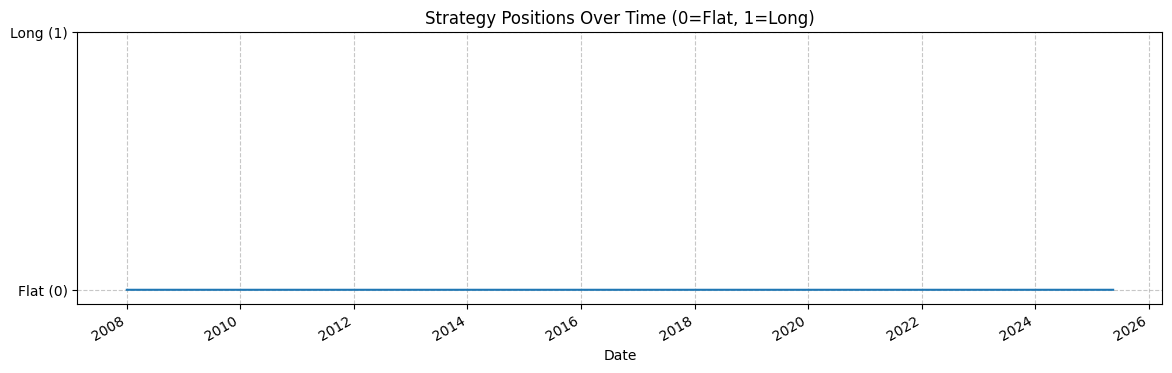

In [6]:
print("--- Inspecting Positions ---")
print("Positions value counts (0: Flat, 1: Long):")
print(positions.value_counts(dropna=False))

print("\nPeriods of holding long (1) or flat (0):")
current_state = positions.iloc[0]
current_start_date = positions.index[0]
for i in range(1, len(positions)):
    if positions.iloc[i] != current_state:
        print(f"  State {current_state} from {current_start_date.date()} to {positions.index[i-1].date()} ({(positions.index[i-1] - current_start_date).days + 1} days)")
        current_state = positions.iloc[i]
        current_start_date = positions.index[i]
print(f"  State {current_state} from {current_start_date.date()} to {positions.index[-1].date()} ({(positions.index[-1] - current_start_date).days + 1} days)")

trade_signals = positions.diff().fillna(0).astype(int)
print("\nTrade signals (1: Buy, -1: Sell, 0: Hold):")
print(trade_signals.value_counts(dropna=False))

actual_trade_dates = trade_signals[trade_signals != 0].index
if not actual_trade_dates.empty:
    print(f"\nActual trade dates ({len(actual_trade_dates)} trades):")
    for trade_date in actual_trade_dates:
        action = "Buy" if trade_signals.loc[trade_date] == 1 else "Sell"
        print(f"  {trade_date.date()}: {action} (Position became {positions.loc[trade_date]})")
else:
    print("\nNo actual trades detected (position did not change significantly). This might indicate the initial position was 0 and never changed, or changed from NaN to 0.")

fig_pos, ax_pos = plt.subplots(figsize=(14, 4))
positions.plot(ax=ax_pos, title="Strategy Positions Over Time (0=Flat, 1=Long)", drawstyle="steps-post")
ax_pos.set_yticks([0, 1])
ax_pos.set_yticklabels(['Flat (0)', 'Long (1)'])
ax_pos.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### 4b. Inspect SMAs and Price


--- Inspecting SMAs and Price ---


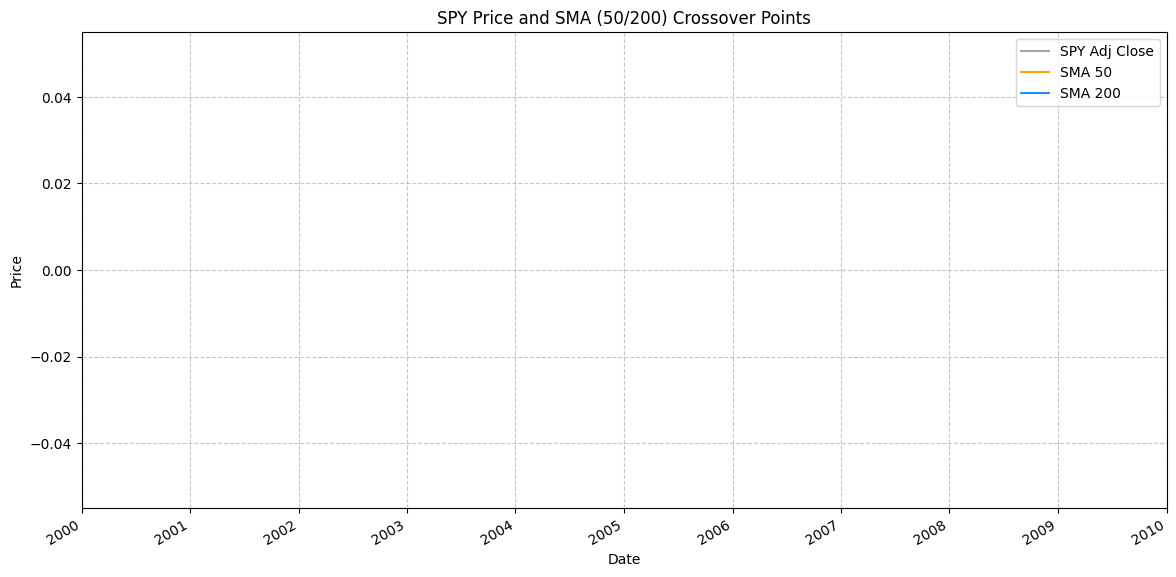

In [7]:
print("\n--- Inspecting SMAs and Price ---")
sma_short_plot = price.rolling(window=short_window, min_periods=short_window).mean()
sma_long_plot = price.rolling(window=long_window, min_periods=long_window).mean()

fig_sma, ax_sma = plt.subplots(figsize=(14, 7))
price.plot(ax=ax_sma, label=f'{tickers[0]} Adj Close', alpha=0.6, color='dimgray')
sma_short_plot.plot(ax=ax_sma, label=f'SMA {short_window}', color='orange')
sma_long_plot.plot(ax=ax_sma, label=f'SMA {long_window}', color='dodgerblue')

if not actual_trade_dates.empty:
    buys = actual_trade_dates[trade_signals.loc[actual_trade_dates] == 1]
    sells = actual_trade_dates[trade_signals.loc[actual_trade_dates] == -1]
    if not buys.empty:
        ax_sma.plot(buys, sma_long_plot.loc[buys], '^', markersize=10, color='lime', alpha=0.8, label='Buy Signal', markeredgecolor='black')
    if not sells.empty:
        ax_sma.plot(sells, sma_long_plot.loc[sells], 'v', markersize=10, color='red', alpha=0.8, label='Sell Signal', markeredgecolor='black')

ax_sma.legend()
ax_sma.set_title(f"{tickers[0]} Price and SMA ({short_window}/{long_window}) Crossover Points")
ax_sma.set_xlabel("Date")
ax_sma.set_ylabel("Price")
ax_sma.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 5. Run Backtest

Simulate the strategy using the `Backtester`.

In [8]:
transaction_cost_bps = 10.0

print("Initializing and running the backtest...")
bt_instance = backtester.Backtester(prices=price, positions=positions, rf=rf, cost_bps=transaction_cost_bps)
result = bt_instance.run()
print("Backtest complete.")

Initializing and running the backtest...
Backtest complete.


### 6. Show Performance Metrics

Display a summary of the strategy's performance.

In [9]:
print("Calculating and displaying performance metrics...")
performance_summary = metrics.summarize(result)
print("\nPerformance Summary:")
print(performance_summary)

Calculating and displaying performance metrics...

Performance Summary:
CAGR (%)             0.838240
Sharpe Ratio        11.385594
Max Drawdown (%)     0.000247
Win Rate (%)        98.787185
Turnover (%)         0.000000
Name: Performance Metrics, dtype: float64


### 7. Plot Results

Visualize the equity curve and drawdown periods.

Plotting equity curve and drawdown periods...


/workspaces/Backtest-Simple/src/metrics.py:126: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(drawdown_series.index, drawdown_series, color='red', lw=0.5)


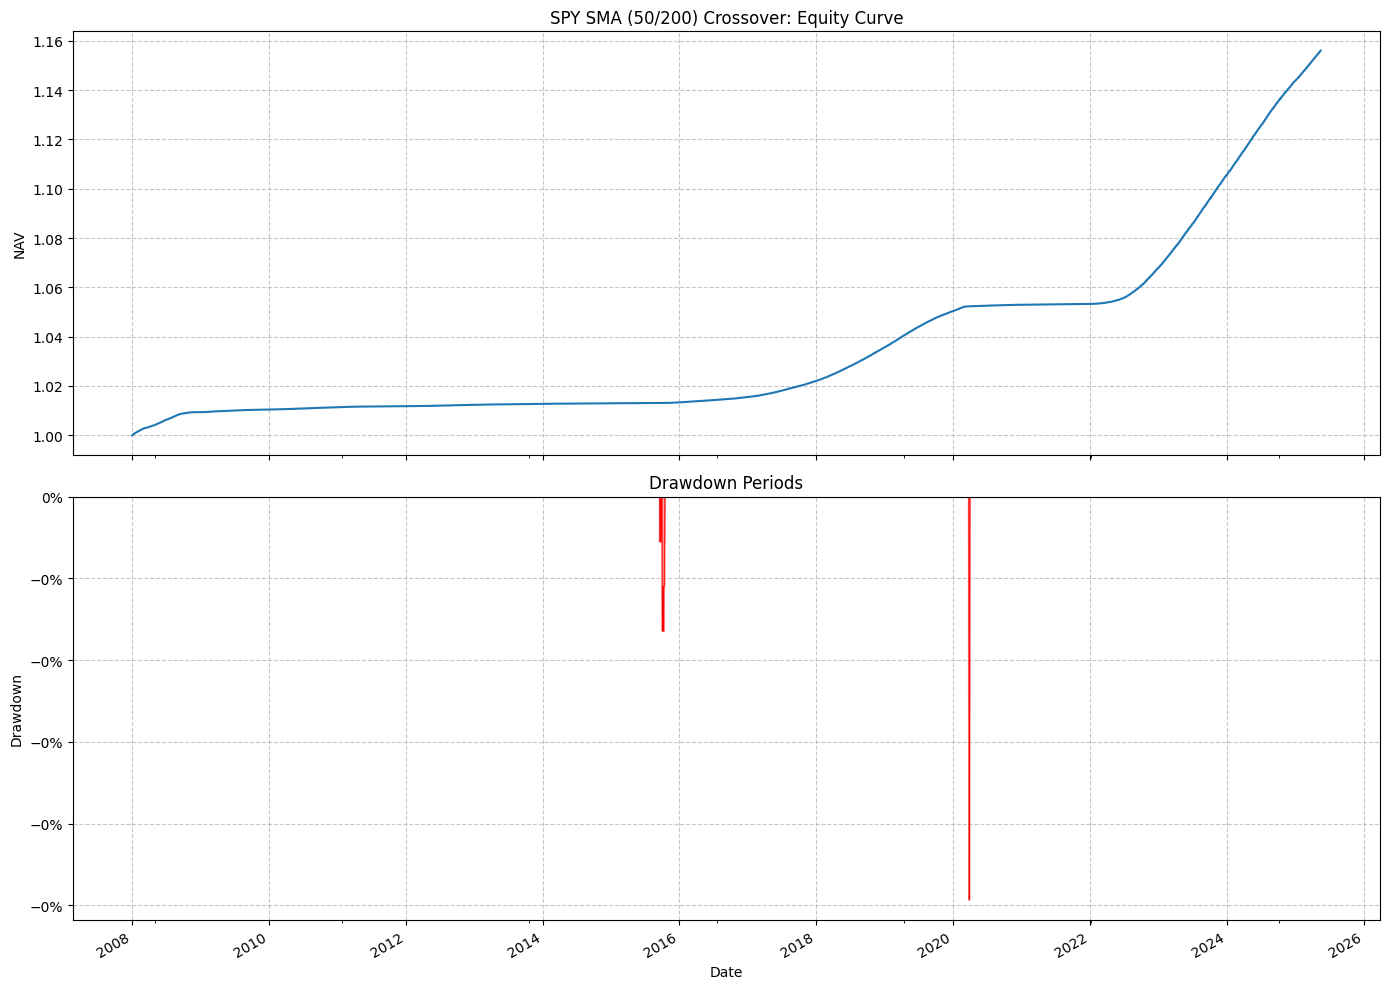

In [10]:
print("Plotting equity curve and drawdown periods...")
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

metrics.plot_equity(result, ax=ax1)
ax1.set_title(f"{tickers[0]} SMA ({short_window}/{long_window}) Crossover: Equity Curve")

metrics.plot_drawdown(result, ax=ax2)
ax2.set_title("Drawdown Periods")

plt.tight_layout()
plt.show()

### Next Steps

- Try different signals or strategies (e.g., momentum, mean reversion, volatility-based models).
- Implement parameter sweeps to optimize strategy parameters (like SMA windows).
- Test the framework with other assets (e.g., QQQ, EFA, IEF) or a portfolio of assets.
- Enhance the `metrics` module with additional performance measures (e.g., Sortino ratio, Calmar ratio, rolling Sharpe ratio, beta, alpha).
- Develop more sophisticated transaction cost models (e.g., including slippage, fixed costs).
- Add support for short selling or different position sizing schemes.